# Imports

In [108]:
from os import stat
import os
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections
%matplotlib inline

# Preparation

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

Transition = collections.namedtuple("Experience", field_names=[
                                    "state", "action", "next_state", "reward", "is_game_on"])

SAVE_PATH = "res"
MODEL_PATH = "RL_models"
SOL_PATH = "sol"
p = [SAVE_PATH, MODEL_PATH, SOL_PATH]
for path in p:
    if not os.path.exists(path):
        os.mkdir(path)


working on cuda:0


# Agent Class

In [110]:
class Agent:
    Transition = collections.namedtuple("Experience", field_names=[
                                        "state", "action", "next_state", "reward", "is_game_on"])
    def __init__(self, maze, memory_buffer, device, use_softmax=True):
        self.env = maze  # the environment (in our case this is a maze)
        self.buffer = memory_buffer  # this is actually a reference
        self.num_act = 4  # number of actions possible
        self.use_softmax = use_softmax  # whether to use softmax or not
        self.total_reward = 0  # total reward
        self.min_reward = -self.env.maze.size  # minimum reward
        self.is_game_on = True  # whether the game is still running or not
        self.device = device  # the device we are using (cpu or cuda)

    def make_move(self, net, epsilon, device):
        # select an action
        action = self.select_action(net, epsilon, device)
        current_state = self.env.state()
        next_state, reward, self.is_game_on = self.env.update_state(action)
        # add to the total reward
        self.total_reward += reward

        if self.total_reward < self.min_reward:  # stop the game in this case
            self.is_game_on = False
        if not self.is_game_on:
            self.total_reward = 0  # reset the total reward

        transition = self.Transition(current_state, action,
                                next_state, reward, self.is_game_on)

        self.buffer.push(transition)

    def select_action(self, net, epsilon, device):
        state = torch.Tensor(self.env.state()).to(device).view(1, -1)
        qvalues = net(state).cpu().detach().numpy().squeeze()

        # softmax sampling of the qvalues
        if self.use_softmax:
            p = sp.softmax(qvalues / epsilon).squeeze()
            p /= np.sum(p)
            action = np.random.choice(self.num_act, p=p)
        else:
            # else choose the best action with probability 1-epsilon
            # and with probability epsilon choose at random
            if np.random.random() < epsilon:
                action = np.random.randint(self.num_act, size=1)[0]
            else:
                action = np.argmax(qvalues, axis=0)
                action = int(action)

        return action

    def plot_policy_map(self, net, filename, offset):
        net.eval()
        with torch.no_grad():
            fig, ax = plt.subplots()
            ax.imshow(self.env.maze, "Greys")

            # loop on all the allowed cells
            for free_cell in self.env.allowed_states:
                # get the action
                self.env.current_pos = np.asarray(free_cell)
                qvalues = net(torch.Tensor(self.env.state()
                                           ).view(1, -1).to(self.device))
                action = int(torch.argmax(qvalues).detach().cpu().numpy())
                # get the policy
                policy = self.env.directions[action]

                ax.text(free_cell[1] - offset[0],
                        free_cell[0]-offset[1], policy)

            ax = plt.gca()
            plt.xticks([], [])
            plt.yticks([], [])
            ax.plot(self.env.goal[1], self.env.goal[0], "bs", markersize=4)
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            plt.show()


# Environment Class

In [111]:
class MazeEnvironment:
    def __init__(self, maze, init_pos, goal):
        x, y = len(maze), len(maze)

        self.bound = np.asarray([x, y])
        self.maze = maze  # the maze
        self.init_pos = init_pos  # the initial position in the maze
        self.goal = goal  # the goal position in the maze
        # the current position, initalize to the start position
        self.current_pos = np.asarray(init_pos)

        self.visited = set()  # a set of all the visited positions in the maze
        self.visited.add(tuple(self.current_pos))

        # initialize the empty cells and the distance (euclidean) from the goal
        # and removing the goal cell
        self.allowed_states = np.asarray(np.where(self.maze == 0)).T.tolist()
        self.distances = np.sqrt(
            np.sum((np.array(self.allowed_states) - np.asarray(self.goal)) ** 2, axis=1))

        del(self.allowed_states[np.where(self.distances == 0)[0][0]])
        self.distances = np.delete(self.distances, np.where(self.distances == 0)[0][0])

        # define action map
        # the agent has 4 possible actions: go right/left/down/up
        self.action_map = {
            0: [0, 1],  # right
            1: [0, -1],  # left
            2: [1, 0],  # down
            3: [-1, 0]  # up
        }

        self.directions = {
            0: "→",
            1: "←",
            2: "↓ ",
            3: "↑"
        }

    def reset_policy(self, eps, reg=7):
        """
        The function reset the policy, so that for high epsilon the inital position is 
        nearer to the goal (very useful for large mazes)
        Args:
            eps - the epsilon value
            reg = regularization value (default 7)
        Return:
            reset policy
        """
        return sp.softmax(-self.distances / (reg * (1 - eps ** (2 / reg))) ** (reg / 2)).squeeze()

    def reset(self, epsilon, prand=0):
        """
        The function reset the environment when the game is completed with a given probability.
        Args:
            epsilon - the epsilon value
            prnad - the probability value for the reset to be random, otherwise, the reset policy
            at the given epsilon is used
        Return:
            reset environment 
        """
        # random reset
        if np.random.rand() < prand:
            index = np.random.choice(len(self.allowed_states))
        else:
            p = self.reset_policy(epsilon)
            index = np.random.choice(len(self.allowed_states), p=p)

        self.current_pos = np.asarray(self.allowed_states[index])

        # initialize the visited positions
        self.visited = set()
        self.visited.add(tuple(self.current_pos))

        return self.state()

    def update_state(self, action):
        """
        The function updates the current state with respect to the given action
        Args:
            action - the selected action
        Return:
            list[maze state, reward, is game on]
        """
        is_game_on = True

        # each move costs -0.05
        reward = -0.05

        move = self.action_map[action]
        next_pos = self.current_pos + np.asarray(move)

        # if the goal has been reached, the agent get a reward of 1
        if (self.current_pos == self.goal).all():
            reward = 1
            is_game_on = False
            return [self.state(), reward, is_game_on]
        else:
            # if the cell has been visited before, the agent get a reward of -0.2
            if tuple(self.current_pos) in self.visited:
                reward = -0.2

        # if the move goes out of the maze or to a wall, the agent get a reward of -1
        if self.is_state_valid(next_pos):
            # change the current pos
            self.current_pos = next_pos
        else:
            reward = -1

        self.visited.add(tuple(self.current_pos))
        return [self.state(), reward, is_game_on]

    def state(self):
        """
        The function returns the state to be feeded to the network
        Return:
            state
        """
        state = copy.deepcopy(self.maze)
        state[tuple(self.current_pos)] = 2
        return state

    def check_boundaries(self, pos):
        """
        The function checks the boundaries
        Args:
            pos - the position to check
        Return:
            bool, whether or not the position is in boundaries
        """
        out = len([n for n in pos if n < 0])
        out += len([n for n in (self.bound - np.asarray(pos)) if n <= 0])
        return out > 0

    def check_wall(self, pos):
        """
        The function checks if the given position is a wall
        Args:
            pos - the position to check
        Return:
            bool, whether or not the position is a wall
        """
        return self.maze[tuple(pos)] == 1

    def is_state_valid(self, pos):
        """
        The function checks if the given position is valid pos
        Args:
            pos - the position to check
        Return:
            bool, whether or not the position is valid
        """
        if self.check_boundaries(pos):
            return False
        if self.check_wall(pos):
            return False
        return True

    def draw(self, filename):
        """
        The function draw some results from the
        Args:
            filename - the filename to save the image
        """
        plt.Figure()
        im = plt.imshow(self.maze, interpolation="none",
                        aspect="equal", cmap="Greys")
        ax = plt.gca()

        plt.xticks([], [])
        plt.yticks([], [])
        ax.plot(self.goal[1], self.goal[0], "bs", markersize=4)
        ax.plot(self.current_pos[1], self.current_pos[0], "rs", markersize=4)
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()


# ExperienceReply Class

In [112]:
class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, next_states, rewards, isgameon = zip(
            *[self.memory[idx] for idx in indices])

        return torch.Tensor(states).type(torch.float).to(device), torch.Tensor(actions).type(torch.long).to(device), torch.Tensor(next_states).to(device), torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)


# Model Class

In [113]:
class fc_nn(nn.Module):
    def __init__(self, input_dim, hiddens: list, output_dim=4):
        super(fc_nn, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hiddens[0]),
            nn.ReLU(),
            nn.Linear(hiddens[0], hiddens[1]),
            nn.ReLU(),
            nn.Linear(hiddens[1], output_dim)
        )

    def forward(self, x):
        out = self.net(x)
        return out


class conv_nn(nn.Module):

    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1

    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels=self.in_channels,
                                            out_channels=self.channels[0],
                                            kernel_size=self.kernels[0],
                                            stride=self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels=self.channels[0],
                                            out_channels=self.channels[1],
                                            kernel_size=self.kernels[1],
                                            stride=self.strides[1]),
                                  nn.ReLU()
                                  )

        size_out_conv = self.get_conv_size(rows, cols)

        self.linear = nn.Sequential(nn.Linear(size_out_conv, rows*cols*2),
                                    nn.ReLU(),
                                    nn.Linear(rows*cols*2, int(rows*cols/2)),
                                    nn.ReLU(),
                                    nn.Linear(int(rows*cols/2), n_act),
                                    )

    def forward(self, x):
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)
        out_lin = self.linear(out_conv)
        return out_lin

    def get_conv_size(self, x, y):
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


# Load The Data

In [114]:
def Q_loss(batch, net, device, gamma=0.99):
    """
    The function compute the Q loss of the given batch
    """
    # unpack the batch
    states, actions, next_states, rewards, _ = batch
    l_batch = len(states)
    state_action_values = net(states.view(l_batch, -1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)

    next_state_values = net(next_states.view(l_batch, -1))
    next_state_values = next_state_values.max(1)[0]
    next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * gamma + rewards
    return nn.MSELoss()(state_action_values, expected_state_action_values)

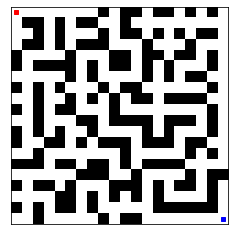

In [115]:
# Load the maze and define the environment
maze = np.load("maze_generator/maze.npy")

initial_position = [0, 0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)
# print and save the maze
maze_env.draw(os.path.join(SAVE_PATH, "maze_20.pdf"))

# define the agent and the buffer for the experience reply object
buffer_capacity = 10_000
buffer_start_size = 1_000
memory_buffer = ExperienceReplay(buffer_capacity)

agent = Agent(maze_env, memory_buffer, device, use_softmax=True)

### Define the model

In [116]:
learning_rate = 1e-4
batch_size = 24
gamma = 0.9
net = fc_nn(maze.size, [maze.size] * 2, 4)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

### Training

In [117]:
num_epochs = 10_000
cutoff = 3_000
epsilon = np.exp(-np.arange(num_epochs) / (cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]
        ] = epsilon[100*int(num_epochs/cutoff)]

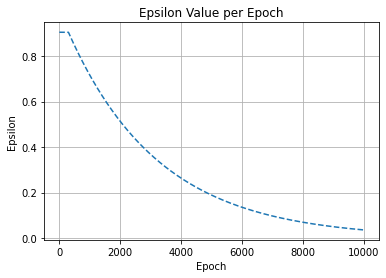

In [118]:
# define the epsilon profile and plot the resetting probability
plt.title("Epsilon Value per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Epsilon")
plt.plot(epsilon, ls="--")
plt.grid()
plt.savefig(os.path.join(SAVE_PATH, "epsilon_profile.pdf"))
plt.show()

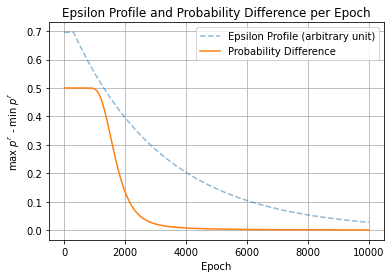

In [119]:
mp, mpm = [], []
reg = 200  # the regularization
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.title("Epsilon Profile and Probability Difference per Epoch")
plt.xlabel("Epoch")
plt.ylabel(r"max $p^r$ - min $p^r$")
plt.plot(epsilon / 1.3, ls="--", alpha=0.5,
         label="Epsilon Profile (arbitrary unit)")
plt.plot(np.array(mpm) - np.array(mp), label="Probability Difference")
plt.grid()
plt.legend()
plt.savefig(os.path.join(SAVE_PATH, "reset_policy.pdf"))
plt.show()

In [120]:
# Training the model
loss_log = []
best_loss = 1e-5
running_loss = 0
estop = -1
for epoch in range(num_epochs):
    loss = 0
    counter = 0  # number of moves
    eps = epsilon[epoch]

    # set the is_game_on to True
    agent.is_game_on = True
    _ = agent.env.reset(eps)

    while agent.is_game_on:
        agent.make_move(net, eps, device)
        counter += 1

        if len(agent.buffer) < buffer_start_size:
            continue

        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device)
        loss_t = Q_loss(batch, net, device, gamma=gamma)
        loss_t.backward()
        optimizer.step()

        loss += loss_t.item()

    if (agent.env.current_pos == agent.env.goal).all():
        result = "won"
    else:
        result = "lost"

    if epoch % 1000 == 0:
        s_p = os.path.join(SOL_PATH, f"sol_epoch_{epoch}.pdf")
        agent.plot_policy_map(net, s_p, [0.35, -0.3])

    loss_log.append(loss)

    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            print("saving model...")
            best_loss = running_loss
            # save the model
            torch.save(net.state_dict(), os.path.join(
                MODEL_PATH, "best_model.torch"))
            estop = epoch

    print(f"Epoch {epoch + 1}, number of moves {counter}")
    print(f"Game result: {result}")

    print("\t Average loss: " + f"{loss:.5f}")
    if (epoch > 2000):
        print("\t Best average loss of the last 50 epochs: " +
              f"{best_loss:.5f}" + ", achieved at epoch", estop)
    clear_output(wait=True)

Epoch 10000, number of moves 22
Game result: won
	 Average loss: 0.00053
	 Best average loss of the last 50 epochs: 0.00001, achieved at epoch -1


In [121]:
# save the model after the training is done
torch.save(net.state_dict(), os.path.join(MODEL_PATH, "net.torch"))

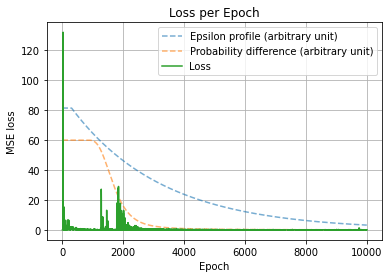

In [122]:
# plot the results of the training
plt.plot(epsilon * 90, alpha=0.6, ls="--",
         label="Epsilon profile (arbitrary unit)")
plt.plot((np.array(mpm) - np.array(mp)) * 120, alpha=0.6, ls="--",
         label="Probability difference (arbitrary unit)")
plt.plot(loss_log, label="Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.grid()
plt.savefig(os.path.join(SAVE_PATH, "loss.pdf"))
plt.show()

In [ ]:
# Show the maze solution and the policy learnt
net.eval()
agent.is_game_on = True
agent.use_softmax = False
_ = agent.env.reset(0)
counter = 0
while agent.is_game_on:
    agent.make_move(net, 0, device)
    if counter % 10 == 0:
        agent.env.draw(os.path.join(SAVE_PATH, f"step_{counter}.pdf"))
    counter += 1
agent.env.draw(os.path.join(SAVE_PATH, f"step_{counter}.pdf"))

In [ ]:
# print the policy map
agent.plot_policy_map(net, os.path.join(
    SAVE_PATH, "solution.pdf"), [0.35, -0.3])

In [ ]:
best_net = copy.deepcopy(net)
best_net.load_state_dict(torch.load(os.path.join(MODEL_PATH, "best_model.torch")))

In [ ]:
agent.plot_policy_map(best_net, os.path.join(
    SAVE_PATH, "best_solution.pdf"), [0.35, -0.3])